Calculate the Bayes Factor for $u-r$ to determine whether the void and wall samples are drawn from the same or different parent distributions.

In [1]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import sys

import pickle

import dynesty
from dynesty import plotting as dyplot

import matplotlib
import matplotlib.pyplot as plt

from functions import Model_1_fit, Model_2_fit, Model_1_plot, Model_2_plot, Model_1_sampler, Model_2_sampler, uniform, jeffreys

#from scipy import stats
#from scipy.optimize import curve_fit
#from scipy.stats import skewnorm

np.set_printoptions(threshold=sys.maxsize)

In [2]:
#matplotlib.rcParams['text.usetex']=True
matplotlib.rc('font', size=14)
#matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='DejaVu Sans')

# Data

In [3]:
data_filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [4]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [9]:
ur_NSA = np.array(catalog_main['u_r'])

## Separate galaxies by their LSS classifications

### $V^2$

In [6]:
wall_v2 = catalog_main['vflag_V2'] == 0
void_v2 = catalog_main['vflag_V2'] == 1
edge_v2 = catalog_main['vflag_V2'] == 2
out_v2 = catalog_main['vflag_V2'] == 9

### VoidFinder

In [7]:
wall_vf = catalog_main['vflag_VF'] == 0
void_vf = catalog_main['vflag_VF'] == 1
edge_vf = catalog_main['vflag_VF'] == 2
out_vf = catalog_main['vflag_VF'] == 9

# Fit the distributions with skewnormal distributions

Both one- and two-parent models

## $u-r$

This is a bimodal distribution

### 1-parent model

In [33]:
ur_fit_bounds1 = [[0.1, 10],    # s ........ Gaussian 1 to 2 scale factor
                  [500, 10000], # a ........ Gaussian a amplitude
                  [1, 2.1],     # mu_a ..... Gaussian a location
                  [1e-5, 2],    # sigma_a .. Gaussian a scale
                  [-10, 10],    # skew_a ... Gaussian a skew
                  [500, 10000], # b ........ Gaussian b amplitude
                  [2.1, 3.5],   # mu_b ..... Gaussian b location
                  [1e-5, 1],    # sigma_b .. Gaussian b scale
                  [-10, 10]]    # skew_b ... Gaussian b skew

ur_bins = np.linspace(0, 4, 170)

V2_ur_bestfit1 = Model_1_fit(ur_fit_bounds1, 
                             ur_NSA[wall_v2], 
                             ur_NSA[void_v2], 
                             ur_bins, 
                             2)

VF_ur_bestfit1 = Model_1_fit(ur_fit_bounds1, 
                             ur_NSA[wall_vf], 
                             ur_NSA[void_vf], 
                             ur_bins, 
                             2)

running minimizer...this might take a few minutes...
running minimizer...this might take a few minutes...


In [34]:
V2_ur_bestfit1

      fun: 2298.6193031917255
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.0133241 ,  0.00163709,  0.44792614,  0.33151082, -0.00331966,
        0.00163709, -0.00973159, -0.20686457,  0.01832632])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2340
      nit: 193
     njev: 234
   status: 0
  success: True
        x: array([  1.91903404, 587.38677011,   1.27366322,   1.00126329,
         5.7181203 , 896.07158427,   2.96796845,   0.9138142 ,
        -5.37156606])

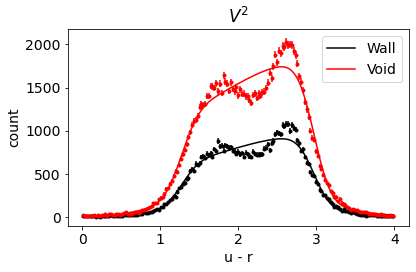

In [35]:
Model_1_plot(V2_ur_bestfit1.x, 
             ur_NSA[wall_v2], 
             ur_NSA[void_v2], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='$V^2$')

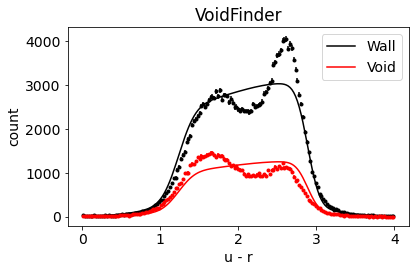

In [36]:
Model_1_plot(VF_ur_bestfit1.x, 
             ur_NSA[wall_vf], 
             ur_NSA[void_vf], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='VoidFinder')

In [37]:
VF_ur_bestfit1

      fun: 6183.071128901383
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.53468136,  0.00254661, -2.09929568,  0.66165739, -0.02046363,
        0.00400182,  1.47501852, -0.0682121 , -0.0349246 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1820
      nit: 152
     njev: 182
   status: 0
  success: True
        x: array([ 4.13466067e-01,  2.06770924e+03,  1.23472294e+00,  8.65089433e-01,
        5.19019107e+00,  2.86785650e+03,  2.88744733e+00,  8.73170101e-01,
       -7.21163317e+00])

#### Nested sampling of Likelihood and Priors

In [38]:
def prior_xform1_bi(u):
    '''
    Priors for the 9 parameters of bimodel M1.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    s = uniform(0.1, 10, u[0])
    a = jeffreys(500, 100000, u[1])
    mu_a = uniform(1, 2.1, u[2])
    sigma_a = uniform(1e-5, 3, u[3])
    skew_a = uniform(-10, 10, u[4])
    b = jeffreys(500, 100000, u[5])
    mu_b = uniform(2.1, 3.5, u[6])
    sigma_b = uniform(1e-5, 3, u[7])
    skew_b = uniform(-10, 10, u[8])

    return s, a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b

In [39]:
Model_1_sampler(prior_xform1_bi, 
                ur_NSA[wall_v2], 
                ur_NSA[void_v2], 
                ur_bins, 
                2, 
                '_ur_V2')

running the nested sampler... this might take from minutes to hours...


39265it [07:40, 85.22it/s, batch: 7 | bound: 375 | nc: 7 | ncall: 328723 | eff(%): 11.945 | loglstar: -2308.109 < -2299.410 < -2301.249 | logz: -2346.282 +/-  0.408 | stop:  0.975]          


sampler output saved as pickle file 'dynesty_output/sampler_results_model1_ur_V2'


In [41]:
temp_infile = open('dynesty_output/sampler_results_model1_ur_V2.pickle', 'rb')
dres1_V2_ur = pickle.load(temp_infile)
temp_infile.close()

In [43]:
labels1_bi = ['s', 'a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 
                    'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$']
labels2_bi = ['$a_1$', r'$\mu_{1a}$', r'$\sigma_{1a}$', 'skew$_{1a}$', 
               '$b_1$', r'$\mu_{1b}$', r'$\sigma_{1b}$', 'skew$_{1b}$', 
               '$a_2$', r'$\mu_{2a}$', r'$\sigma_{2a}$', 'skew$_{2a}$', 
               '$b_2$', r'$\mu_{2b}$', r'$\sigma_{2b}$', 'skew$_{2b}$']

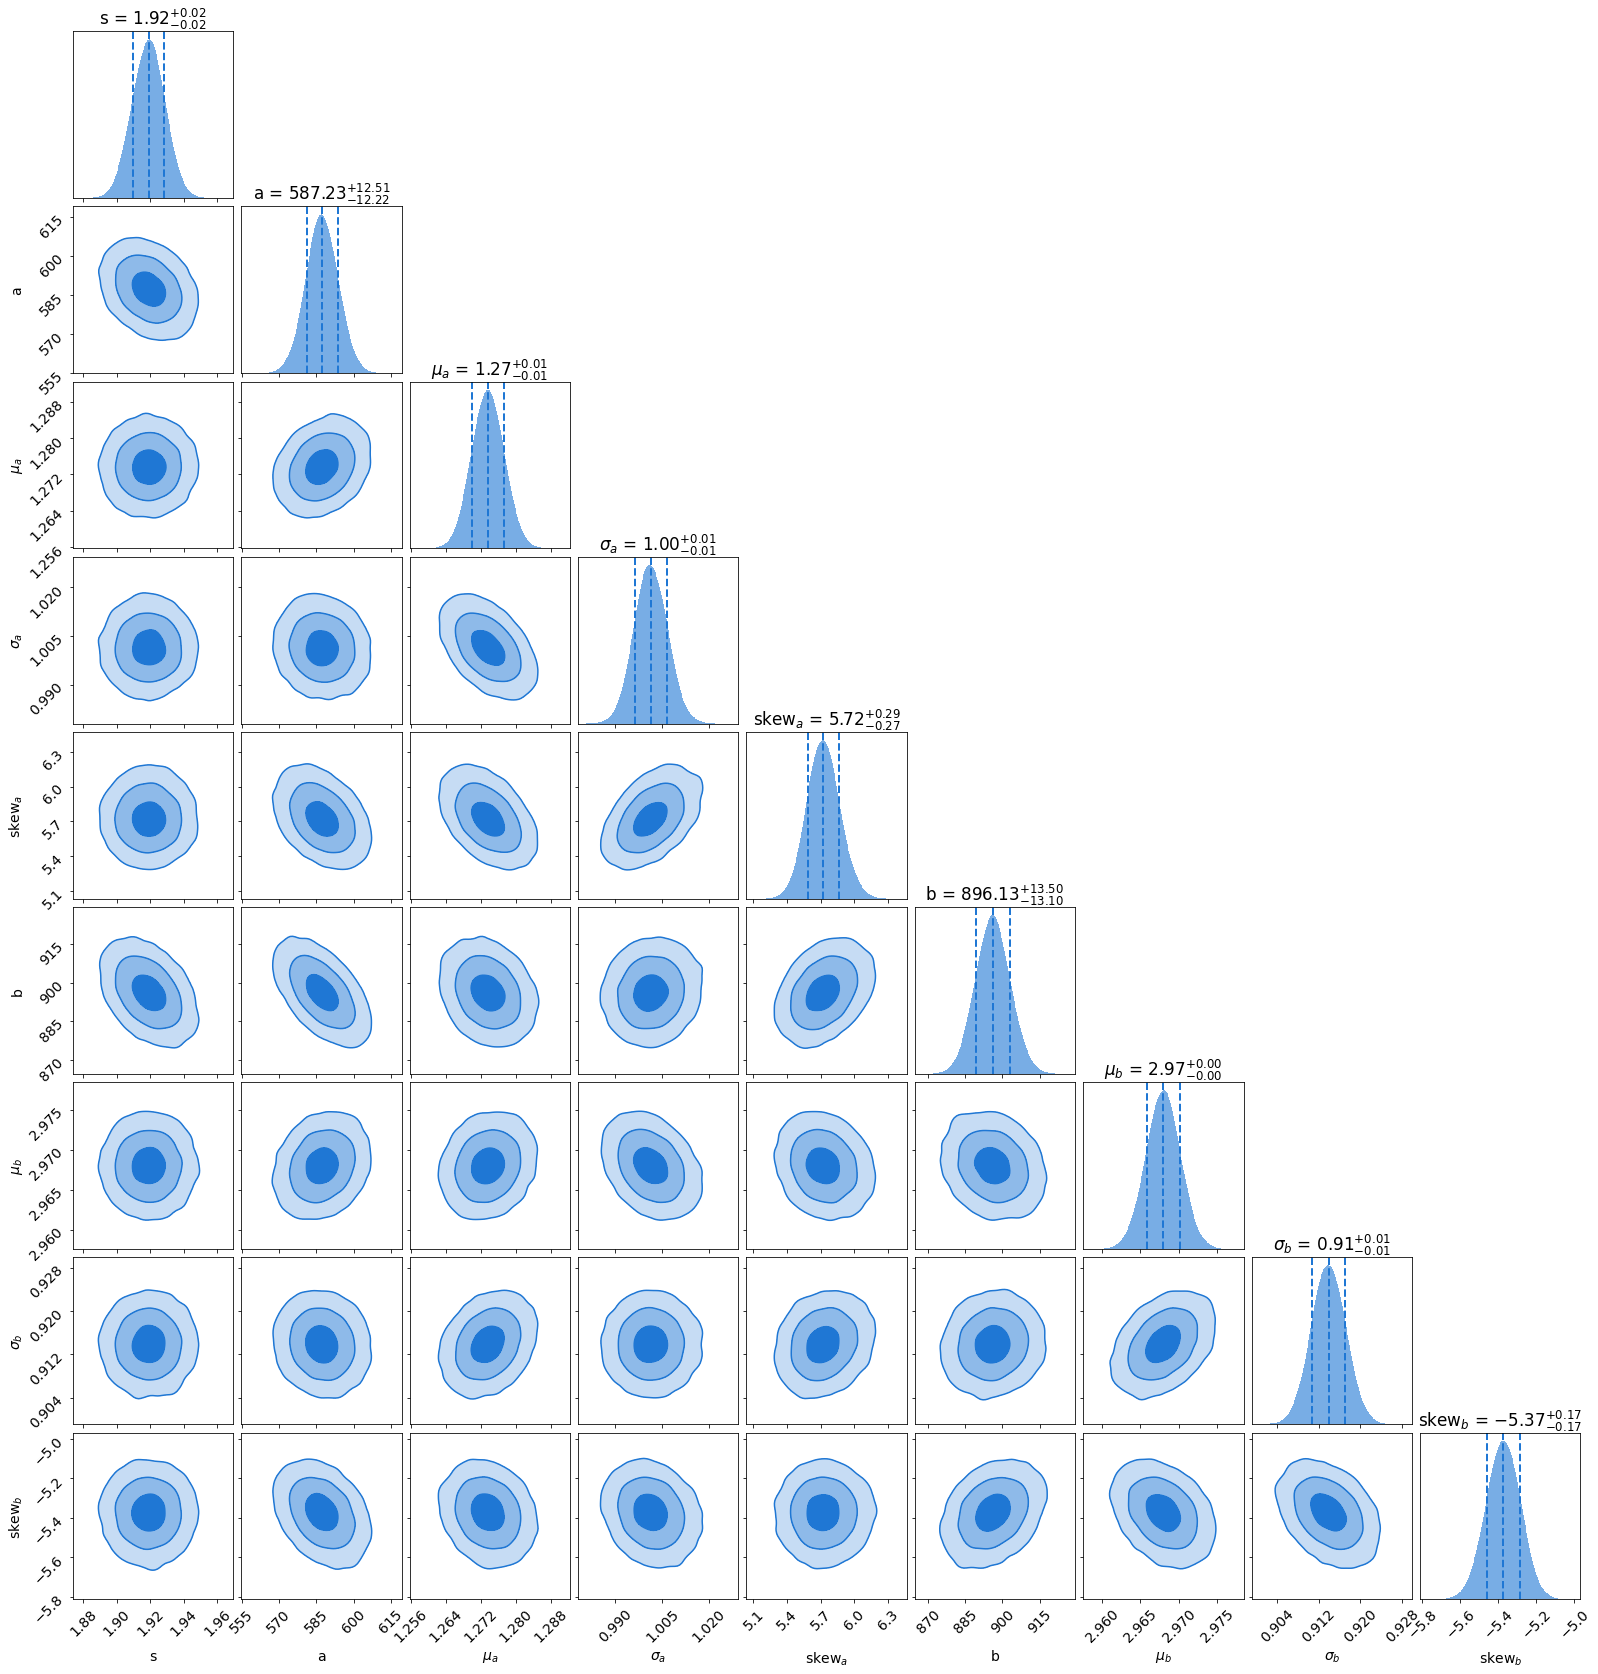

In [44]:
fig, axes = dyplot.cornerplot(dres1_V2_ur, smooth=0.03, 
                              labels=labels1_bi, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(9, 9, figsize=(2.5*9, 2.6*9)), 
                              color='#1f77d4')

In [45]:
lnzM1_V2_Mstar = dres1_V2_Mstar.logz[-1]
lnzM1_V2_Mstar

-2346.270709193069

In [46]:
Model_1_sampler(prior_xform1_bi, 
                ur_NSA[wall_vf], 
                ur_NSA[void_vf], 
                ur_bins, 
                2, 
                '_ur_VoidFinder')

running the nested sampler... this might take from minutes to hours...


42854it [41:07, 17.37it/s, batch: 8 | bound: 3717 | nc: 13 | ncall: 3183195 | eff(%):  1.346 | loglstar: -6192.925 < -6183.406 < -6185.941 | logz: -6234.354 +/-  0.424 | stop:  0.906]         


sampler output saved as pickle file 'dynesty_output/sampler_results_model1_rabsmag_VoidFinder'


In [50]:
temp_infile = open('dynesty_output/sampler_results_model1_ur_VoidFinder.pickle', 'rb')
dres1_VF_ur = pickle.load(temp_infile)
temp_infile.close()

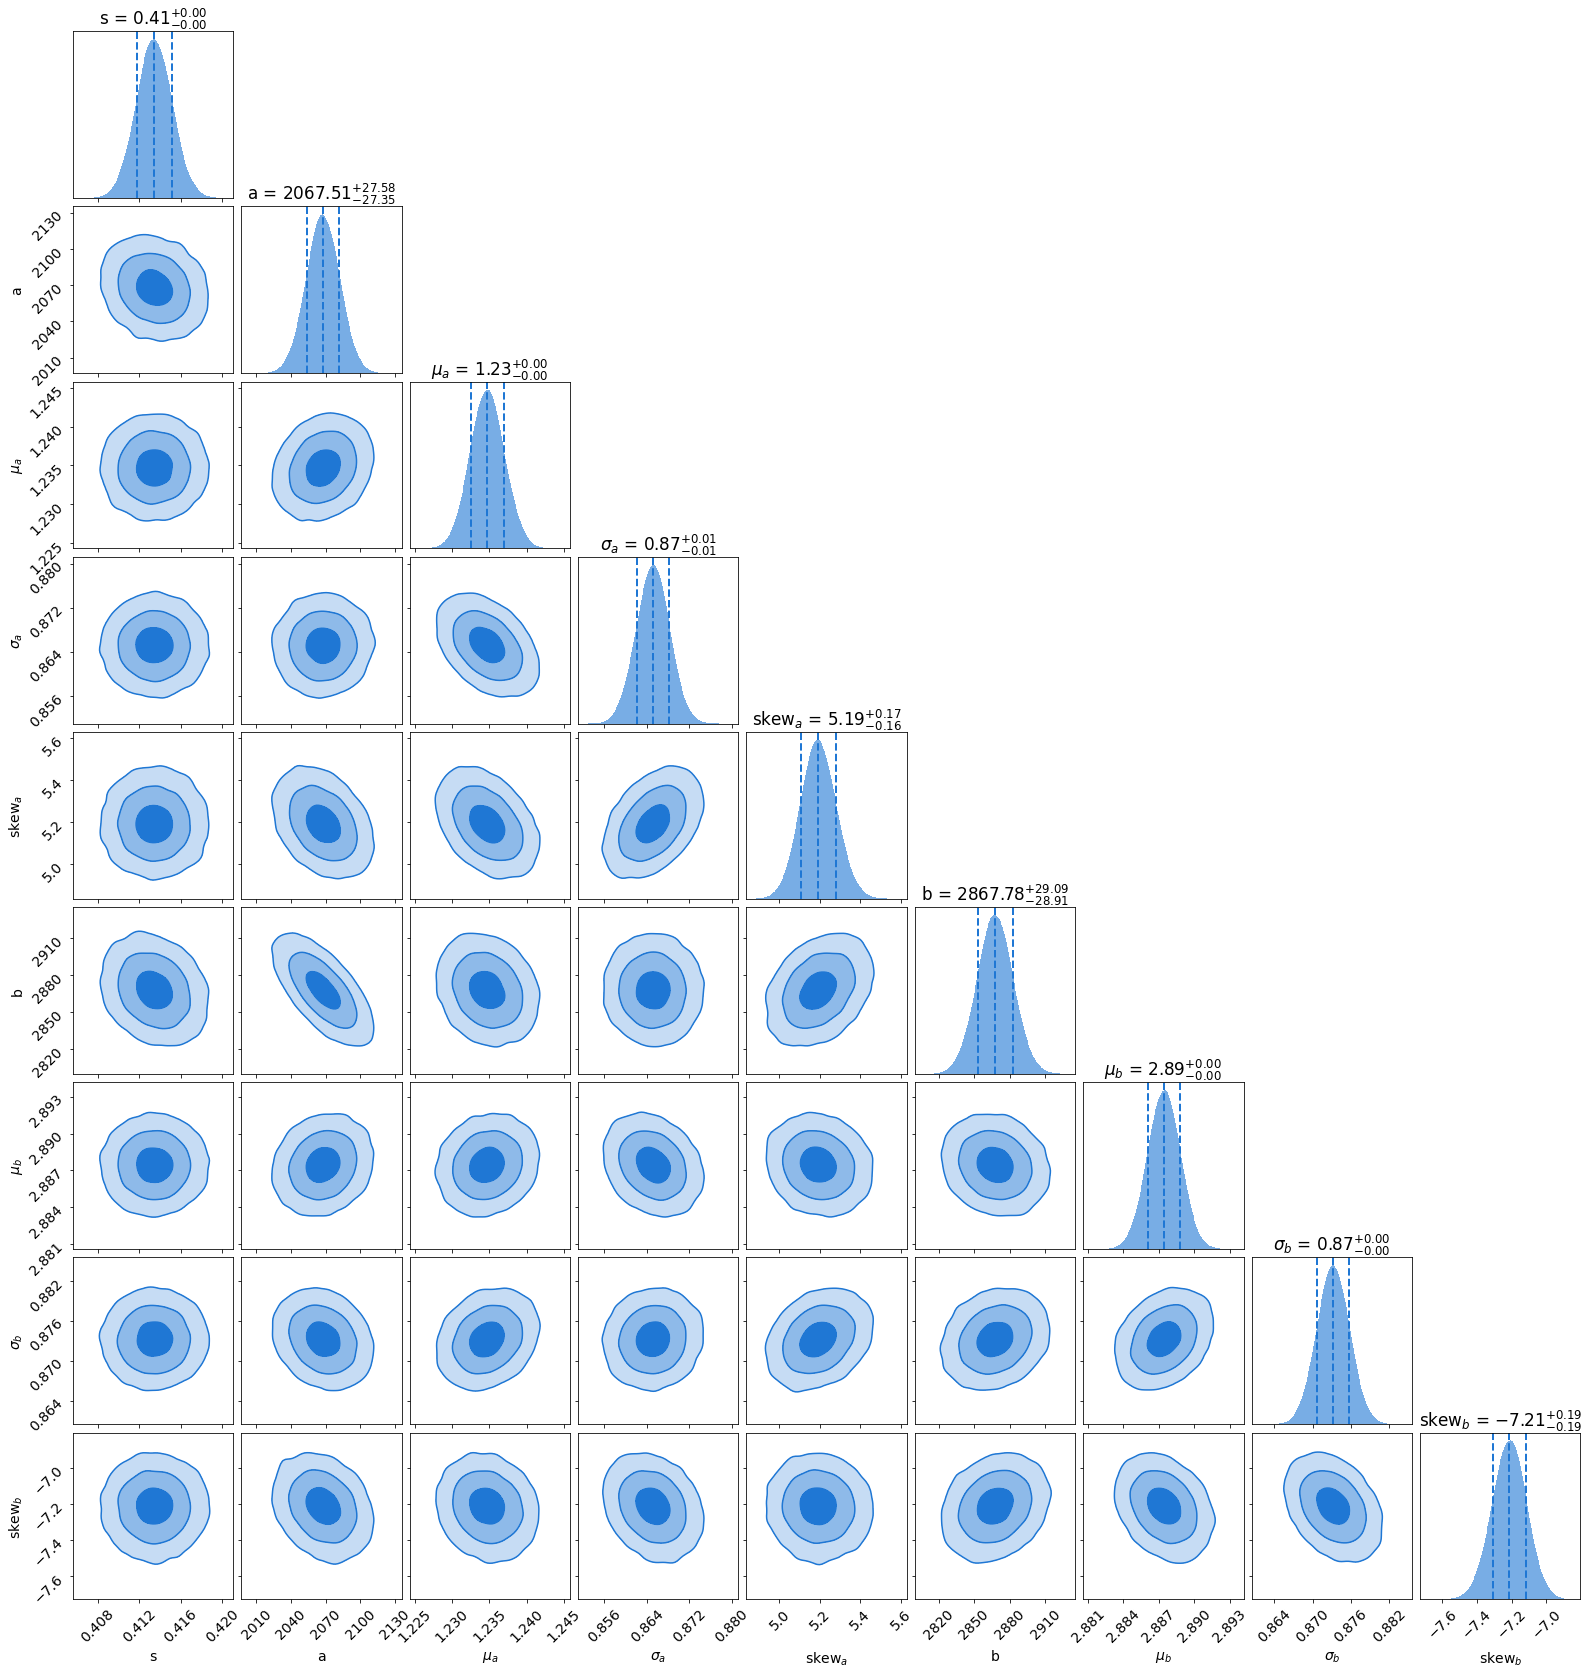

In [51]:
fig, axes = dyplot.cornerplot(dres1_VF_ur, smooth=0.03, 
                              labels=labels1_bi, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(9, 9, figsize=(2.5*9, 2.6*9)), 
                              color='#1f77d4')

In [52]:
lnzM1_VF_ur = dres1_VF_ur.logz[-1]
lnzM1_VF_ur

-6234.3567638655895

### 2-parent model

In [21]:
Mstar_fit_bounds2 = [[500, 10000], # a ........ Gaussian A amplitude
                     [8, 12],      # mu_a ..... Gaussian A location
                     [0.1, 3],     # sigma_a .. Gaussian A scale
                     [-5, 5],      # skew_a ... Gaussian A skew
                     [500, 10000], # b ........ Gaussian B amplitude
                     [8, 12],      # mu_b ..... Gaussian B location
                     [0.1, 3],     # sigma_b .. Gaussian B scale
                     [-5, 5]]      # skew_b ... Gaussian B skew

V2_Mstar_bestfit2 = Model_2_fit(Mstar_fit_bounds2, 
                                Mstar_NSA[wall_v2], 
                                Mstar_NSA[void_v2], 
                                Mstar_bins, 
                                1)

VF_Mstar_bestfit2 = Model_2_fit(Mstar_fit_bounds2, 
                                Mstar_NSA[wall_vf], 
                                Mstar_NSA[void_vf], 
                                Mstar_bins, 
                                1)

running minimizer...this might take a few minutes...
running minimizer...this might take a few minutes...


In [22]:
V2_Mstar_bestfit2

      fun: 6171.650394697996
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.07039563,  1.2856616 , -0.95842551, -0.00418368,  0.44893133,
        0.90303721,  0.60354068,  0.03637979])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 630
      nit: 60
     njev: 70
   status: 0
  success: True
        x: array([ 2.88222266e+03,  1.07378201e+01,  9.11579910e-01, -3.55978644e+00,
        5.62260329e+03,  1.07442265e+01,  9.25825899e-01, -3.68025460e+00])

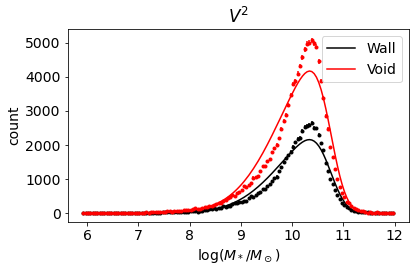

In [23]:
Model_2_plot(V2_Mstar_bestfit2.x, 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             1, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$')

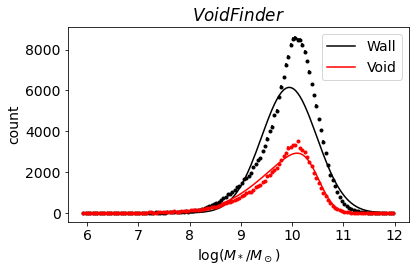

In [24]:
Model_2_plot(VF_Mstar_bestfit2.x, 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             Mstar_bins, 
             1, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$VoidFinder$')

In [25]:
VF_Mstar_bestfit2

      fun: 16745.635450473448
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.25718443e+00,  2.28133558e+03, -1.81338021e+04,  1.04176543e+03,
        4.19463392e-01, -5.77982744e+02, -1.99905843e+02, -5.88588595e+01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 711
      nit: 65
     njev: 79
   status: 0
  success: True
        x: array([ 8.30527941e+03,  1.00595935e+01,  5.51084648e-01, -2.75950586e-01,
        4.02489481e+03,  1.05060419e+01,  9.42289926e-01, -3.69217707e+00])

#### Nested sampling of Likelihood and Priors

In [ ]:
def prior_xform2_uni(u):
    '''
    Priors for the 8 parameters of unimodel M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a = jeffreys(500, 100000, u[0])
    mu_a = uniform(8, 12, u[1])
    sigma_a = uniform(0.1, 3, u[2])
    skew_a = uniform(-5, 5, u[3])

    b = jeffreys(500, 100000, u[4])
    mu_b = uniform(8, 12, u[5])
    sigma_b = uniform(0.1, 3, u[6])
    skew_b = uniform(-5, 5, u[7])

    return a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b

In [23]:
Model_2_sampler(prior_xform2_uni, 
                Mstar_NSA[wall_v2], 
                Mstar_NSA[void_v2], 
                Mstar_bins, 
                1, 
                '_Mstar_V2')

running the nested sampler... this might take from minutes to hours...


38639it [05:22, 119.98it/s, batch: 7 | bound: 176 | nc: 2 | ncall: 153061 | eff(%): 25.244 | loglstar: -6154.292 < -6145.892 < -6148.609 | logz: -6192.125 +/-  0.406 | stop:  0.994]        


NameError: name 'label' is not defined

In [26]:
temp_infile = open('dynesty_output/sampler_results_model2_Mstar_V2.pickle', 'rb')
dres2_V2_Mstar = pickle.load(temp_infile)
temp_infile.close()

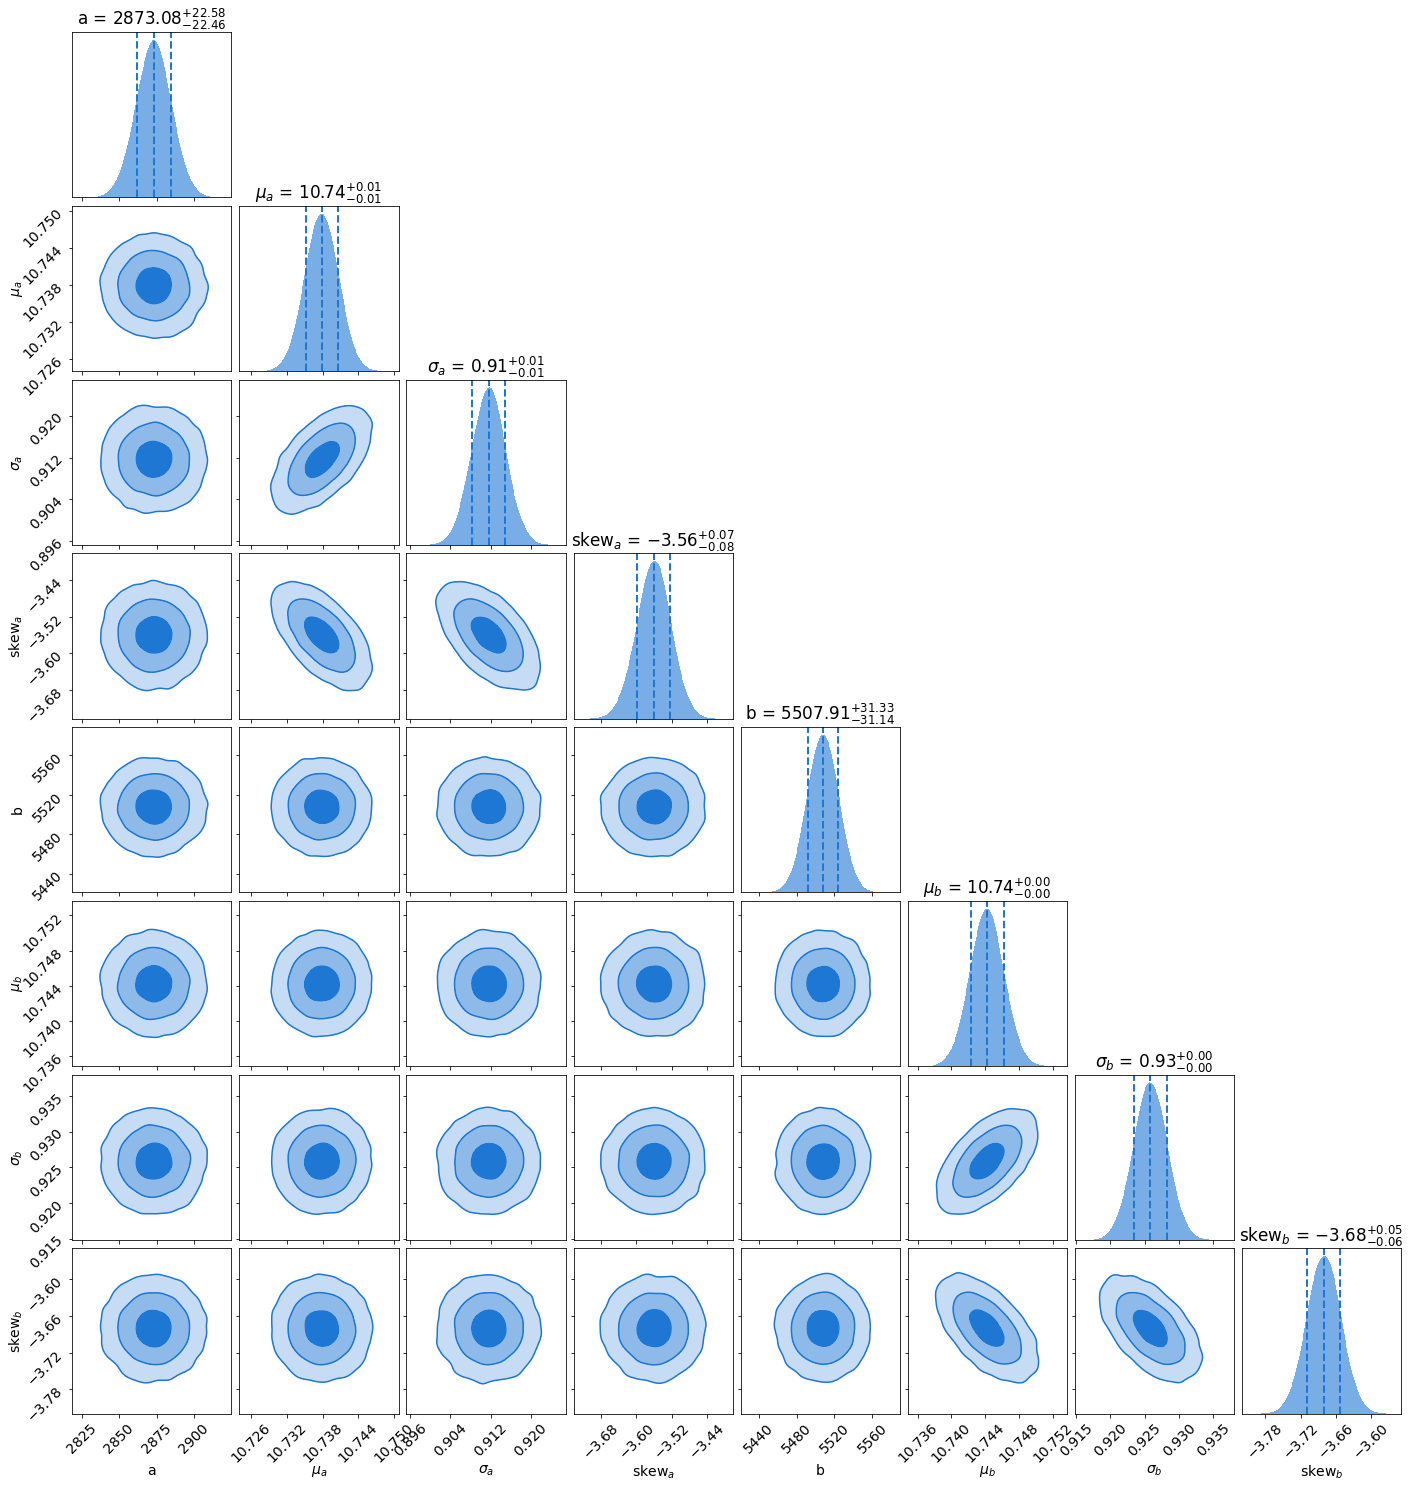

In [27]:
fig, axes = dyplot.cornerplot(dres2_V2_Mstar, smooth=0.03, 
                              labels=labels2_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(8, 8, figsize=(2.5*8, 2.6*8)), 
                              color='#1f77d4')

In [28]:
lnzM2_V2_Mstar = dres2_V2_Mstar.logz[-1]
lnzM2_V2_Mstar

-6192.142169928759

In [29]:
Model_2_sampler(prior_xform2_uni, 
                Mstar_NSA[wall_vf], 
                Mstar_NSA[void_vf], 
                Mstar_bins, 
                1, 
                '_Mstar_VoidFinder')

running the nested sampler... this might take from minutes to hours...


39499it [05:52, 111.98it/s, batch: 7 | bound: 256 | nc: 3 | ncall: 220527 | eff(%): 17.911 | loglstar: -4684.045 < -4675.468 < -4677.982 | logz: -4723.138 +/-  0.412 | stop:  0.872]         


sampler output saved as pickle file 'dynesty_output/sampler_results_model2_Mstar_VoidFinder'


In [30]:
temp_infile = open('dynesty_output/sampler_results_model2_Mstar_VoidFinder.pickle', 'rb')
dres2_VF_Mstar = pickle.load(temp_infile)
temp_infile.close()

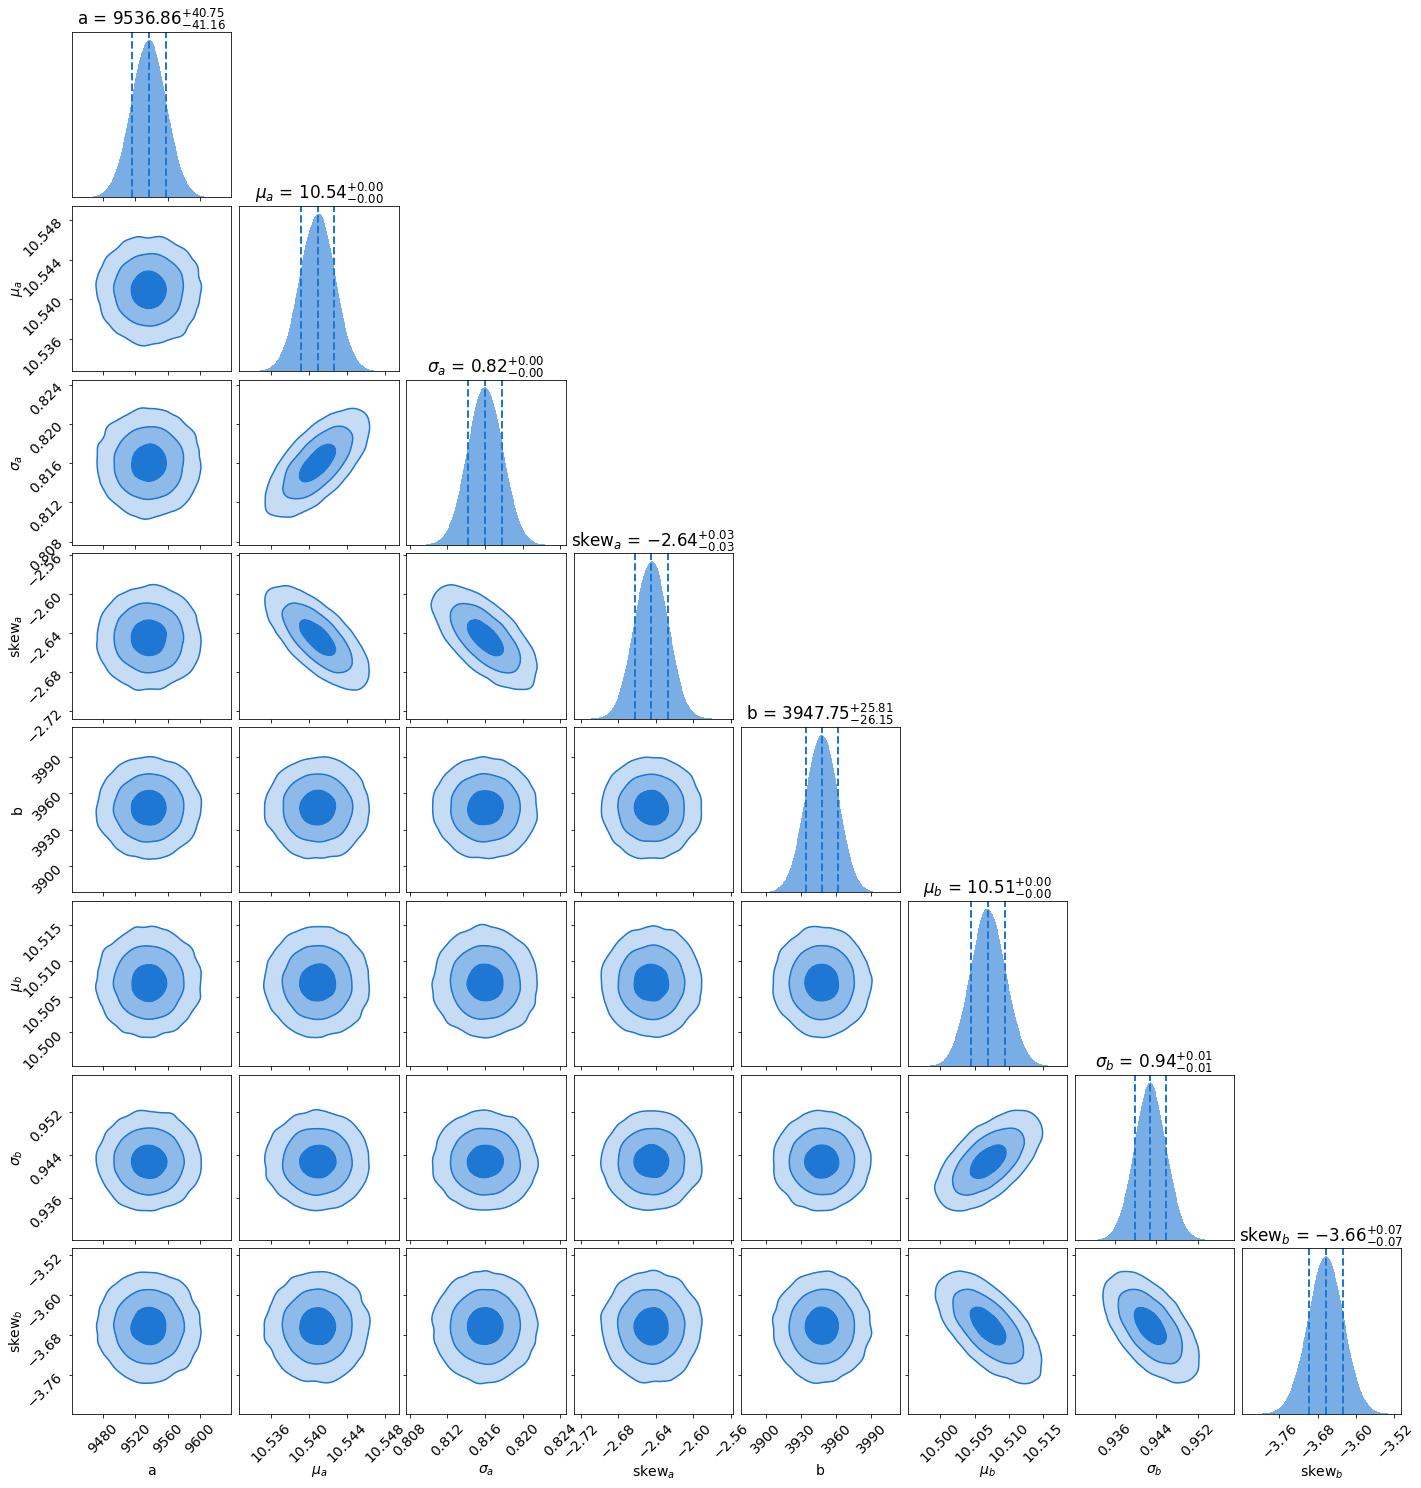

In [31]:
fig, axes = dyplot.cornerplot(dres2_VF_Mstar, smooth=0.03, 
                              labels=labels2_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(8, 8, figsize=(2.5*8, 2.6*8)), 
                              color='#1f77d4')

In [32]:
lnzM2_VF_Mstar = dres2_VF_Mstar.logz[-1]
lnzM2_VF_Mstar

-4723.141704809133

## Bayes Factor

In [28]:
lnB12_V2_Mstar = lnzM1_V2_Mstar - lnzM2_V2_Mstar

B12_V2_Mstar = np.exp(lnB12_V2_Mstar)

print('V2 Mstar: B12 = {:.3g}; log(B12) = {:.3g}'.format(B12_V2_Mstar, np.log10(B12_V2_Mstar)))

V2 Mstar: B12 = 1.04e+04; log(B12) = 4.02


In [37]:
lnB12_VF_Mstar = lnzM1_VF_Mstar - lnzM2_VF_Mstar

B12_VF_Mstar = np.exp(lnB12_VF_Mstar)

#print('VoidFinder Mstar: B12 = {:.3g}; log(B12) = {:.3g}'.format(B12_VF_Mstar, np.log10(B12_VF_Mstar)))
print('VoidFinder Mstar: B12 = {:.3g}; log(B12) = {:.3f}'.format(B12_VF_Mstar, lnB12_VF_Mstar*np.log10(np.exp(1))))

VoidFinder Mstar: B12 = 0; log(B12) = -1034.589


So model $\mathcal{M}_1$, in which the two data sets come from the same parent distribution, is overwhelmingly favored by four orders of magnitude for the $V^2$ $M_*$ distribution.

And model $\mathcal{M}_2$, in which the two data sets come from different parent distributions, is overwhelmingly favored by 1000 orders of magnitude for the VoidFinder $M_*$ distribution.